In [36]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [245]:
class GDN(tf.keras.layers.Layer):
    def __init__(self,
                 n_channels,
                 gamma_init=.1,
                 reparam_offset=2**(-18),
                 beta_min=1e-6,
                 apply_independently=False):

        super(GDN, self).__init__()
        self.n_channels = n_channels
        self.gamma_init = gamma_init
        self.reparam_offset = reparam_offset
        self.beta_min = beta_min
        self.beta_reparam = (self.beta_min+self.reparam_offset**2)**(1/2)
        self.apply_independently = apply_independently

        if apply_independently:
            self.groups = n_channels
        else:
            self.groups = 1

        self.initialise_params()
        
    def initialise_params(self):
        ## First we define gamma
        gamma = tf.eye(self.n_channels)
        gamma = tf.reshape(gamma, shape=(*gamma.shape,1,1))
        gamma = tf.sqrt(self.gamma_init*gamma + self.reparam_offset**2)
        gamma = tf.multiply(gamma, gamma)

        if self.apply_independently:
            gamma = tf.expand_dims(gamma[:,0,:,:], axis=1)

        self.gamma = tf.Variable(initial_value=gamma,
                                 trainable=True,
                                 name="gamma")

        ## Now we can define beta
        beta = tf.ones(shape=(self.n_channels,))
        beta = tf.sqrt(beta + self.reparam_offset**2)
        self.beta = tf.Variable(initial_value=beta,
                                trainable=True,
                                name="beta")

    def build(self, input_shape):
        """
        We could probably get rid of the n_channels variable
        by building some of the parameters here, but I'd make sure
        that we understand it and then we play around.
        """

        self.conv = tf.keras.layers.Conv2D(filters=self.gamma.shape[1],
                              kernel_size=self.gamma.shape[2:4],
                              padding="valid",
                              strides=1,
                              groups=self.groups,
                              data_format="channels_first",
                              trainable=False)

        self.conv.build(input_shape)
        # self.gamma = self.add_weight("gamma",
        #                              shape=[input_shape])
        # pass

    def call(self, X):
        """
        The PyTorch implementation works with inputs of shape:
        [batch_size, channels, height, width].
        We'll first copy it and then we'll try to change it.
        """
        self.gamma = tf.clip_by_value(self.gamma,
                                      clip_value_min=self.reparam_offset,
                                      clip_value_max=tf.float32.max)
        self.beta = tf.clip_by_value(self.beta,
                                     clip_value_min=self.beta_reparam,
                                     clip_value_max=tf.float32.max)

        self.conv.weights[0].assign(self.gamma)
        self.conv.weights[1].assign(self.beta)
        norm_pool = self.conv(tf.multiply(X, X))
        norm_pool = tf.sqrt(norm_pool)

        return X / norm_pool

In [246]:
gdn = GDN(n_channels=1)

In [247]:
np.random.seed(42)
sample_input = np.random.uniform(size=(1,1,28,28))
# sample_input = tf.random.uniform(shape=(1,1,28,28))

In [248]:
gdn.gamma.shape, gdn.beta.shape

(TensorShape([1, 1, 1, 1]), TensorShape([1]))

In [249]:
a = gdn(sample_input)

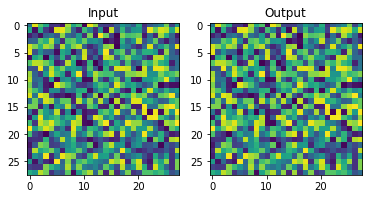

In [250]:
plt.figure()
plt.subplot(1,2,1)
plt.title("Input")
plt.imshow(sample_input.squeeze())
plt.subplot(1,2,2)
plt.imshow(a.numpy().squeeze())
plt.title("Output")
plt.show()

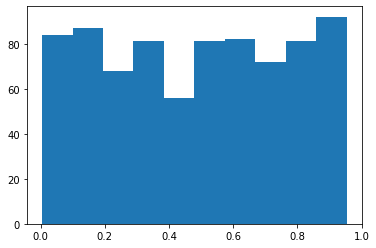

In [251]:
plt.figure()
plt.hist(a.numpy().squeeze().ravel())
plt.show()

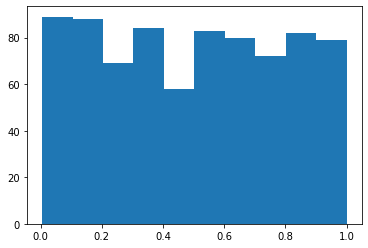

In [252]:
plt.figure()
plt.hist(sample_input.squeeze().ravel())
plt.show()

In [243]:
t1 = np.array([1,2,3])
t2 = np.array([4,5,6])

t1, t2

(array([1, 2, 3]), array([4, 5, 6]))

In [244]:
tf.multiply(t1, t2)

<tf.Tensor: shape=(3,), dtype=int64, numpy=array([ 4, 10, 18])>